<a href="https://colab.research.google.com/github/anasmghouri/Coursera_Capstone/blob/main/The_Battle_of_Neighborhoods_p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of Neighborhoods in Munich

Project by: Anas Ghouri

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

# **Introduction**: Business Problem <a name="introduction"></a>

Munich is considered as an economical capital of Germany. Therefore it offers enormous opportunities for enterprenours to test their business ideas. As it is  one of the biggest cities of Germany, the plan has to be competitive, well reasoned and convincing to be even considered by any investor.

Following project is trying to find **optimal location** in **Munich** to open a **Rent a Car** business. 

Munich, due to its central location in Europe, hosts a lot of tourists and passerbys in its Hostels, AirBnbs and other types of accomodations. Rent a Car businesses, in Munich, enjoy the privilege of this location and are established in major locations in Munich. 

The aim of this project is to find those areas which are great locations for such a business but have not been explored so far.

To narrow down our search, we would focus on finding such a location which is **densily populated**, have a **lot of accomodations nearby** but also has a **low competition risk** for the new business.

We will use data from various sources and use data science tools to analyse neighborhoods and select the best location.

# **Data** <a name="data"></a>

Following are the factors which will guide us to the optimal location for a new Rent a Car business:
* Cluster of potential airbnb locations nearby.
* The density of the neighborhoods should be high.
* Should be distant from the competitors.

The data will be collected as follows:
* List of Neighborhoods and their population density.
* List of districts in each Neighborhood.
* Using Nominatim to find the corrdinates of all the neighborhoods and districts.
* List of hosts from Airbnb and their accomodation coordinates.
* Using Foursquar API to find the the existing competitors in Rent a Car business in every district.
* Using K means clustering to find optimal locations

To process the data, the following liberaries are imported:

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import re
import json # library to handle JSON files
!pip install geopandas

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

from math import radians, cos, sin, asin, sqrt

!pip install geopy
from geopy.exc import GeocoderTimedOut 
from geopy.geocoders import Nominatim
print('Libraries imported.')

     |████████████████████████████████| 994 kB 5.4 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.6 MB 31.8 MB/s 
Libraries imported.


### Data Source 1: 
**Munich Neighborhoods and their population density:**

> ["Stadtbezirke Münchens"](https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens)

In [ ]:
url = "https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens"
html = requests.get(url).content
df_list = pd.read_html(html)
Mnc_popp = df_list[0]
Mnc_popp.rename(columns={'Nr.': 'No#', 'Stadtbezirk': 'Borough', 'Fläche(km²)': 'Area_km2', 'Einwohner': 'Population', 'Dichte(Einw./km²)': 'Density_Pop/km2', 'Ausländer(%)': 'Foreigners_%'}, inplace=True)
Mnc_popp['Area_km2'] = Mnc_popp['Area_km2'].div(100).round(2)
Mnc_popp['Foreigners_%'] = Mnc_popp['Foreigners_%'].div(10).round(2)
Mnc_popp.head()

No#                       Borough  Area_km2 Population  Density_Pop/km2  \
0  1.0                Altstadt-Lehel      3.15     20.960            6.663   
1  2.0  Ludwigsvorstadt-Isarvorstadt      4.40     51.547           11.711   
2  3.0                   Maxvorstadt      4.30     51.530           11.989   
3  4.0                Schwabing-West      4.36     68.750           15.756   
4  5.0                 Au-Haidhausen      4.22     62.353           14.776   

   Foreigners_%  
0          25.2  
1          28.2  
2          25.6  
3          22.9  
4          23.6

### Data Source 2: 
**A dataframe of Munich AirBnB listings:**

> ["Get the Data"](http://insideairbnb.com/get-the-data.html)



In [ ]:
Munich_bnb = pd.read_csv (r'http://data.insideairbnb.com/germany/bv/munich/2021-03-22/visualisations/listings.csv')
Munich_bnb = Munich_bnb.reset_index(drop=True)

In [ ]:
print(Munich_bnb.shape)
Munich_bnb.head()

(5073, 16)


id                                   name  host_id host_name  \
0   97945       Deluxw-Apartm. with roof terrace   517685  Angelika   
1  114695     Apartment Munich/East with sundeck   581737   Stephan   
2  127383      City apartment next to Pinakothek   630556     Sonja   
3  159634    Fancy, bright central roof top flat   765694     Sanna   
4  170154  Own floor & bath, parking & breakfast   108297      Alex   

   neighbourhood_group       neighbourhood  latitude  longitude  \
0                  NaN              Hadern  48.11476   11.48782   
1                  NaN        Berg am Laim  48.12071   11.63758   
2                  NaN         Maxvorstadt  48.15199   11.56482   
3                  NaN  Pasing-Obermenzing  48.13898   11.46612   
4                  NaN   Sendling-Westpark  48.10814   11.52733   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt     80               2                129  2019-10-03   
1  Entire home/apt     95               2                 53  2019-10-06   
2  Entire home/apt     99               2                 94  2020-12-30   
3  Entire home/apt     52               5                 34  2020-12-23   
4     Private room     55               2                478  2020-11-13   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               1.12                               2                 5  
1               0.45                               2               169  
2               0.79                               1                 0  
3               0.29                               1                 0  
4               4.12                               1               275

### Data Source 3: 
**Shapes of Munich Neighborhoods (for Folium maps):**

> ["Get the Data"](http://insideairbnb.com/get-the-data.html)

In [ ]:
# download neighbourhood geojson file
neighborhood_shapes_json = 'http://data.insideairbnb.com/germany/bv/munich/2021-03-22/visualisations/neighbourhoods.geojson'

### Data Source 4: 
**Total Districts in each Munich Neighborhood:**

> ["Stadtbezirke Münchens"](https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens)

In [ ]:
Mnc_boroughs = df_list[1]
Mnc_boroughs.rename(columns={'Stadt-bezirks-nr.': 'Borough_No', 'Stadtbezirk': 'Borough', 'Stadtbezirksteile (Nr.)': 'Districts'}, inplace=True)
Mnc_boroughs['Districts'] = Mnc_boroughs['Districts'].str.findall(r'(?:[^\),]+(?=\s\(\d+\)))')
Mnc_boroughs.head()

Borough_No                       Borough  \
0           1                Altstadt-Lehel   
1           2  Ludwigsvorstadt-Isarvorstadt   
2           3                   Maxvorstadt   
3           4                Schwabing-West   
4           5                 Au-Haidhausen   

                                           Districts  
0  [Graggenau,  Angerviertel,  Hackenviertel,  Kr...  
1  [Gärtnerplatz,  Deutsches Museum,  Glockenbach...  
2  [Königsplatz,  Augustenstraße,  St. Benno,  Ma...  
3  [Neuschwabing,  Am Luitpoldpark,  Schwere-Reit...  
4  [Maximilianeum,  Steinhausen,  Haidhausen-Nord...

To create a tablular dataframe of Munich Districts, we will modify the above dataframe:

In [ ]:
Mnc_districts = Mnc_boroughs['Districts'].apply(pd.Series)
Mnc_districts = Mnc_districts.rename(columns = lambda x : 'dist_' + str(x))
Mnc_districts_obj = Mnc_districts.select_dtypes(['object'])
Mnc_districts[Mnc_districts_obj.columns] = Mnc_districts_obj.apply(lambda x: x.str.strip())

In [ ]:
Mnc_districts_list = Mnc_districts.columns.values.tolist()
Mnc_districts_list

['dist_0',
 'dist_1',
 'dist_2',
 'dist_3',
 'dist_4',
 'dist_5',
 'dist_6',
 'dist_7',
 'dist_8']

In [ ]:
Mnc_boroughs_districts = pd.concat([Mnc_boroughs[:], Mnc_districts[:]], axis=1)
Mnc_boroughs_districts.head()

Borough_No                       Borough  \
0           1                Altstadt-Lehel   
1           2  Ludwigsvorstadt-Isarvorstadt   
2           3                   Maxvorstadt   
3           4                Schwabing-West   
4           5                 Au-Haidhausen   

                                           Districts         dist_0  \
0  [Graggenau,  Angerviertel,  Hackenviertel,  Kr...      Graggenau   
1  [Gärtnerplatz,  Deutsches Museum,  Glockenbach...   Gärtnerplatz   
2  [Königsplatz,  Augustenstraße,  St. Benno,  Ma...    Königsplatz   
3  [Neuschwabing,  Am Luitpoldpark,  Schwere-Reit...   Neuschwabing   
4  [Maximilianeum,  Steinhausen,  Haidhausen-Nord...  Maximilianeum   

             dist_1                 dist_2          dist_3  \
0      Angerviertel          Hackenviertel    Kreuzviertel   
1  Deutsches Museum            Glockenbach      Dreimühlen   
2    Augustenstraße              St. Benno        Marsfeld   
3   Am Luitpoldpark  Schwere-Reiter-Straße             NaN   
4       Steinhausen        Haidhausen-Nord  Haidhausen-Süd   

                        dist_4                        dist_5  \
0                        Lehel         Englischer Garten Süd   
1  Am alten südlichen Friedhof                Am Schlachthof   
2                 Josephsplatz  Am alten nördlichen Friedhof   
3                          NaN                           NaN   
4                     Obere Au                     Untere Au   

                     dist_6             dist_7        dist_8  
0                       NaN                NaN           NaN  
1  Ludwigsvorstadt-Kliniken           St. Paul           NaN  
2               Universität  Schönfeldvorstadt  Maßmannbergl  
3                       NaN                NaN           NaN  
4                       NaN                NaN           NaN

In [ ]:
dfs = {}
Mnc_all_districts = pd.DataFrame()

for i in Mnc_districts_list:
  dfs[i] = Mnc_boroughs_districts[['Borough_No','Borough', i]]
  dfs[i] = dfs[i].rename(columns={i:'Districts'})
  Mnc_all_districts = pd.concat([Mnc_all_districts, dfs[i]], ignore_index=True)

In [ ]:
Mnc_all_districts = Mnc_all_districts.sort_values('Borough_No')
Mnc_all_districts = Mnc_all_districts.dropna()
Mnc_all_districts = Mnc_all_districts.reset_index(drop=True)

Final dataframe of Munich Neighborhoods and their Districts:

In [ ]:
Mnc_all_districts.head()

Borough_No         Borough              Districts
0           1  Altstadt-Lehel              Graggenau
1           1  Altstadt-Lehel          Hackenviertel
2           1  Altstadt-Lehel           Kreuzviertel
3           1  Altstadt-Lehel           Angerviertel
4           1  Altstadt-Lehel  Englischer Garten Süd

### Data Source 5: 
**Nominatim:** Fetching the Longitudes and Latitudes of the Neighborhoods and Districts

In [ ]:
def findGeocode(address):

    try:

        geolocator = Nominatim(user_agent="my_explorer")
          
        return geolocator.geocode(address)
      
    except GeocoderTimedOut:
          
        return findGeocode(address)

Fetching postal codes of Districts of Munich:

In [ ]:
Mnc_all_districts["District+Mnc"] = Mnc_all_districts["Districts"] + ", Munich"

In [ ]:
longitude = []
latitude = []

for i in (Mnc_all_districts["District+Mnc"]):
      
  if findGeocode(i) != None:
    loc = findGeocode(i)
          
    # coordinates returned from function is stored into two separate list
    latitude.append(loc.latitude)
    longitude.append(loc.longitude)

  elif findGeocode(i.replace(",", "")) != None:
    loc = findGeocode(i.replace(",", ""))
      
    latitude.append(loc.latitude)
    longitude.append(loc.longitude)

    # if coordinate for a city not found, insert "NaN" indicating missing value 
  else:
    latitude.append(np.nan)
    longitude.append(np.nan)

In [ ]:
Mnc_all_districts["Dist_Lat"] = latitude
Mnc_all_districts["Dist_Long"] = longitude

In [ ]:
Mnc_all_districts.head()

Borough_No         Borough              Districts  \
0           1  Altstadt-Lehel              Graggenau   
1           1  Altstadt-Lehel          Hackenviertel   
2           1  Altstadt-Lehel           Kreuzviertel   
3           1  Altstadt-Lehel           Angerviertel   
4           1  Altstadt-Lehel  Englischer Garten Süd   

                    District+Mnc   Dist_Lat  Dist_Long  
0              Graggenau, Munich  48.139563  11.580182  
1          Hackenviertel, Munich  48.135731  11.569955  
2           Kreuzviertel, Munich  48.139698  11.573209  
3           Angerviertel, Munich  48.133670  11.571569  
4  Englischer Garten Süd, Munich  48.148353  11.591236

Checking, if our district data is complete! 

The only following item that is missing in our list of district compared to the complete list of boroughs of Munich, is the incorrect name. This is actually Munich city itself and not a borough.

In [ ]:
Mnc_popp[~Mnc_popp['Borough'].isin(Mnc_all_districts['Borough'])]

No#                   Borough  Area_km2 Population  Density_Pop/km2  \
25  NaN  Landeshauptstadt München    310.71  1.562.096            5.027   

    Foreigners_%  
25          28.6

# **Methodology** <a name="methodology"></a>

In the first step, this project will analyse the above data to find the potential business locations in Munich with the help of Airbnb data.

Secondly, we will find analyse the Airbnb locations and the potential competitors and remove those areas from our list which have hard competition.

Thirdly, we will follow the densily populated neighborhoods and if we find those potential locations over there, then we will select them.


### **Now its time to explore the city**

Lets get the Latitude and Longitude of the city center of Munich:

(Actual center of the city is Marienplatz but its not a geographical center of the city, therefore Olympiapark is taken to centerlize the map)

In [ ]:
munich_center = findGeocode('Olympiapark, Munich')
c_latitude = munich_center.latitude
c_longitude = munich_center.longitude

print('The geograpical coordinate of Olympiapark, Munich are {}, {}.'.format(c_latitude, c_longitude))

The geograpical coordinate of Olympiapark, Munich are 48.16875265, 11.55032660696114.


In [ ]:
Marienplatz = findGeocode('Marienplatz, Munich')
Marienplatz_cordi = [Marienplatz.latitude, Marienplatz.longitude]

print('The geograpical coordinate of Marienplatz, Munich are {}.'.format(Marienplatz_cordi))

The geograpical coordinate of Marienplatz, Munich are [48.137031750000006, 11.575924590567384].


Importing the shapes of the Munich Neighborhoods for the folium map:

In [ ]:
import geopandas

munich_neighb_geodf = geopandas.read_file(neighborhood_shapes_json)

Fixing some errors in the Neighborhood names:

In [ ]:
Mnc_popp[~Mnc_popp['Borough'].isin(munich_neighb_geodf['neighbourhood'])]

No#                   Borough  Area_km2 Population  Density_Pop/km2  \
14  15.0            Trudering-Riem     22.45     74.456            3.316   
16  17.0   Obergiesing-Fasangarten      5.72     53.897            9.421   
25   NaN  Landeshauptstadt München    310.71  1.562.096            5.027   

    Foreigners_%  
14          23.7  
16          31.2  
25          28.6

In [ ]:
munich_neighb_geodf['neighbourhood'] = munich_neighb_geodf['neighbourhood'].str.replace('Obergiesing','Obergiesing-Fasangarten')
munich_neighb_geodf['neighbourhood'] = munich_neighb_geodf['neighbourhood'].str.replace('Tudering-Riem','Trudering-Riem')

In [ ]:
munich_neighbourhoods = munich_neighb_geodf.to_json()

## Map to show the population density of Munich Neighborhoods and their districts:

Note:
*   Darker Red Neighborhood = Densily populated
*   Green Circles = Munich districts
*   White Circle = Marienplatz (Munich Center)

In [ ]:
# create map of Munich using latitude and longitude values
map_munich = folium.Map(location=[c_latitude, c_longitude], zoom_start=12)

map_munich.choropleth(
    geo_data=munich_neighbourhoods,
    data=Mnc_popp,
    columns=['Borough', 'Density_Pop/km2'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2
)

folium.Circle(location=Marienplatz_cordi, radius=3000, color='white').add_to(map_munich)

# add markers to map
for lat, lng, borough, district in zip(Mnc_all_districts['Dist_Lat'], Mnc_all_districts['Dist_Long'], Mnc_all_districts['Borough'], Mnc_all_districts['Districts']):
    label = '{}, {}'.format(district, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green').add_to(map_munich)   

folium.Marker(location=Marienplatz_cordi).add_to(map_munich)

map_munich

/usr/local/lib/python3.7/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


^^ The above map shows that the city center has more Districts than the rest of the city.

## Map to show the locations of Air B&B offered in Munich:

Note:
*   Air B&B offering in Munich (Blue dots)
*   Boroughs (Red Shapes)

In [ ]:
# create map of Munich using latitude and longitude values
bnb_map_munich = folium.Map(location=[c_latitude, c_longitude], zoom_start=12)

bnb_map_munich.choropleth(
    geo_data=munich_neighbourhoods,
    data=Mnc_popp,
    columns=['Borough', 'Density_Pop/km2'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2
)

# add markers to map
for lat, lng in zip(Munich_bnb['latitude'], Munich_bnb['longitude']):
    folium.Circle(
        [lat, lng],
        radius=0.1,
        color='blue').add_to(bnb_map_munich)

folium.Circle(location=Marienplatz_cordi, radius=3000, color='white').add_to(bnb_map_munich)

bnb_map_munich

/usr/local/lib/python3.7/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


^^ The above map shows that there are more Air Bnb offering in and around the city center than the rest of the city.

We can also assume that the more the AirBnb offering are around an area the better it would be for the potential new Rent a Car business.

# **Using Foursquare to find competitors:**

In [1]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


**Let's explore a district in our dataframe as an example.**

We randomly selected District 5 in our district list

In [ ]:
District_latitude = Mnc_all_districts.loc[4, 'Dist_Lat'] #  latitude value
District_longitude = Mnc_all_districts.loc[4, 'Dist_Long'] # longitude value

District_name = Mnc_all_districts.loc[4, 'Districts'] 

print('Latitude and longitude values of {} are {}, {}.'.format(District_name, 
                                                               District_latitude, 
                                                               District_longitude))

Latitude and longitude values of Englischer Garten Süd are 48.148353400000005, 11.59123572462537.


In [ ]:
radius = 1500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    District_latitude, 
    District_longitude, 
    radius, 
    LIMIT)

In [ ]:
results = requests.get(url).json()

In [ ]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


name           categories        lat        lng
0                          Eisbach                River  48.146976  11.591129
1              Kleine Eisbachwelle            Surf Spot  48.147923  11.592359
2                 Schwabinger Bach                River  48.148136  11.587635
3                Chinesischer Turm  Monument / Landmark  48.152362  11.592436
4  Biergarten am Chinesischen Turm          Beer Garden  48.152501  11.592347

In [ ]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## **Explore All Districts in Munich for 'Car Rental Service':**

In [ ]:
# The category code for car rental service is:
category_id = '4bf58dd8d48988d1ef941735'

# reference: https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            category_id, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Districts', 
                  'Dist_Lat', 
                  'Dist_Long', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

**The above function has been run on each district and it created a new dataframe called *munich_venues*:**

In [ ]:
munich_venues = getNearbyVenues(names= Mnc_all_districts['Districts'],
                                   latitudes= Mnc_all_districts['Dist_Lat'],
                                   longitudes= Mnc_all_districts['Dist_Long']
                                  )
print('All district venues imported')

All district venues imported


In [ ]:
munich_venues = munich_venues.reset_index(drop=True)

In [ ]:
print(munich_venues.shape)
munich_venues.head()

(753, 7)


Districts   Dist_Lat  Dist_Long  \
0  Graggenau  48.139563  11.580182   
1  Graggenau  48.139563  11.580182   
2  Graggenau  48.139563  11.580182   
3  Graggenau  48.139563  11.580182   
4  Graggenau  48.139563  11.580182   

                                               Venue  Venue_Lat  Venue_Long  \
0                                    SIXT rent a car  48.140912   11.584563   
1  SIXT Autovermietung München Hofbräuhaus - Digi...  48.137254   11.581381   
2  SIXT Autovermietung München/Hotel Bayerischer Hof  48.140454   11.573066   
3                                 Budget Deutschland  48.134347   11.577923   
4                                   Avis Deutschland  48.134295   11.578037   

        Venue_Category  
0  Rental Car Location  
1  Rental Car Location  
2  Rental Car Location  
3  Rental Car Location  
4  Rental Car Location

Lets plot them in the Map of Munich:

In [ ]:
# create map of Munich using latitude and longitude values
car_rental_munich = folium.Map(location=[c_latitude, c_longitude], zoom_start=12)

car_rental_munich.choropleth(
    geo_data=munich_neighbourhoods,
    data=Mnc_popp,
    columns=['Borough', 'Density_Pop/km2'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2
)

folium.Circle(location=Marienplatz_cordi, radius=3000, color='white').add_to(car_rental_munich)

# add markers to map
for lat, lng in zip(munich_venues['Venue_Lat'], munich_venues['Venue_Long']):
    folium.Circle(
        [lat, lng],
        radius=0.1,
        color='blue').add_to(car_rental_munich)

car_rental_munich

/usr/local/lib/python3.7/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Lets plot Airbnb as **Heat Map** along with the Rent a Car competitors in Munich

In [ ]:
density_airbnb = folium.Map(location=[c_latitude, c_longitude], zoom_start=12)

folium.TileLayer('cartodbpositron').add_to(density_airbnb) #cartodbpositron cartodbdark_matter

heat_data = [[row['latitude'],row['longitude']] for index, row in Munich_bnb.iterrows()]

HeatMap(heat_data).add_to(density_airbnb)

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

folium.GeoJson(munich_neighbourhoods, style_function=boroughs_style).add_to(density_airbnb)

for lat, lng in zip(munich_venues['Venue_Lat'], munich_venues['Venue_Long']):
    folium.Circle(
        [lat, lng],
        radius=2,
        color='black').add_to(density_airbnb)

density_airbnb

^^ The above map shows that most of the competitors are within the area where most of the Airbnbs offerings are present.

Now we can remove those Airbnbs locations in your list which are **within the 500 meter distance** of the existing Rent a Car business.

# Finding the right cluster of areas for the target market:

Define a function to find if the location is within the defined vicinity of another location, in this case to find the airbnb locations within a 'Rent a Car' business vicinity:

In [ ]:
Munich_bnb_temp = Munich_bnb.copy()

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

Short listing the locations where there is no competition within 500 meters.

In [ ]:
for i, rowv in munich_venues.iterrows():
  lat_center = rowv["Venue_Lat"]
  lon_center = rowv["Venue_Long"]
  for j, rowO in Munich_bnb_temp.iterrows():
    lat_location = rowO["latitude"]
    lon_location = rowO["longitude"]
    radius = 0.500 # in kilometer (500 meters equal to approx 6 min of walk)
    a = haversine(lon_center, lat_center, lon_location, lat_location)
    if a <= radius:
      Munich_bnb_temp.at[j, 'Vicinity'] = 'Inside'

In [ ]:
Munich_bnb.shape

(5073, 16)

In [ ]:
Munich_bnb_Outside = Munich_bnb_temp.loc[Munich_bnb_temp['Vicinity'] != 'Inside']

In [ ]:
Munich_bnb_Outside.shape

(2610, 17)

**Cluster the Remaining Airbnb regions, with K-means:**

Now we will use K means clustering to find the right number of clusters and their centers as potential areas for new business.

In [ ]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = Munich_bnb_Outside[['latitude']]
X_axis = Munich_bnb_Outside[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

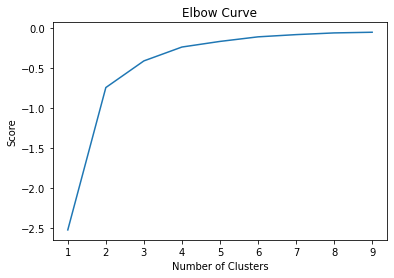

In [ ]:
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()

We can see that with the Elbow Curve method, the **3 clusters** would fit optimally.

In [ ]:
# Variable with the Longitude and Latitude
X=Munich_bnb_Outside.loc[:,['id','latitude','longitude']]

In [ ]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering. # Compute k-means clustering.

X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

X.head(10)

id  latitude  longitude  cluster_label
0    97945  48.11476   11.48782              1
1   114695  48.12071   11.63758              0
2   127383  48.15199   11.56482              2
3   159634  48.13898   11.46612              1
4   170154  48.10814   11.52733              1
5   170815  48.16071   11.54314              2
7   172672  48.16341   11.56366              2
8   179640  48.14453   11.63769              0
9   183634  48.17532   11.44526              1
10  186596  48.12198   11.57644              2

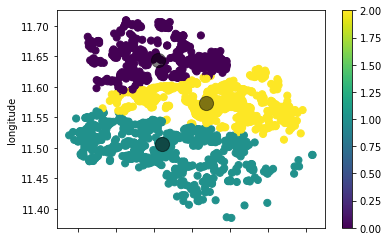

In [ ]:
X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

These are the centroids of the 3 clusters:

In [ ]:
centers

array([[48.12760391, 11.64479918],
       [48.13013124, 11.50565312],
       [48.15894873, 11.57415984]])

# **Results** <a name="results"></a>

Lets plot the resultant centroids in Folium Munich map to see where they are:

In [ ]:
Potential_locations = folium.Map(location=[c_latitude, c_longitude], zoom_start=12)

folium.TileLayer('cartodbpositron').add_to(Potential_locations) #cartodbpositron cartodbdark_matter

heat_data = [[row['latitude'],row['longitude']] for index, row in Munich_bnb_Outside.iterrows()]

HeatMap(heat_data).add_to(Potential_locations)

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

folium.GeoJson(munich_neighbourhoods, style_function=boroughs_style).add_to(Potential_locations)

for x in centers:
    folium.Circle(x, radius=1000, fill=True, fill_opacity=0.6, color='white').add_to(Potential_locations)

Potential_locations

It looks like the area in Schwabing West South (The Northern K-Means center), called 'Neuschwabing' is empty of any Car Rental Business and densly populated.

Lets zoom the map and highlight the northern centroid in a circle:

In [ ]:
schwbing_lat_long = list(centers[2])

In [ ]:
car_rental_schwbing = folium.Map(location=schwbing_lat_long, zoom_start=15)

car_rental_schwbing.choropleth(
    geo_data=munich_neighbourhoods,
    data=Mnc_popp,
    columns=['Borough', 'Density_Pop/km2'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2
)

# add markers to map
for lat, lng in zip(munich_venues['Venue_Lat'], munich_venues['Venue_Long']):
    folium.Circle(
        [lat, lng],
        radius=0.1,
        color='blue').add_to(car_rental_schwbing)

folium.Circle(location=schwbing_lat_long, radius=500, color='white').add_to(car_rental_schwbing)
folium.Marker(location=schwbing_lat_long).add_to(car_rental_schwbing)

car_rental_schwbing

/usr/local/lib/python3.7/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


^^ Above map shows that this centroid is within the Densily populated neighborhood and it is far from the competitors..

Now lets see, how this centroid looks like around the Airbnb locations..

In [ ]:
Heatmap_schwbing = folium.Map(location=schwbing_lat_long, zoom_start=15)

folium.TileLayer('cartodbpositron').add_to(Heatmap_schwbing) #cartodbpositron cartodbdark_matter

heat_data = [[row['latitude'],row['longitude']] for index, row in Munich_bnb_Outside.iterrows()]

HeatMap(heat_data).add_to(Heatmap_schwbing)

folium.Circle(location=schwbing_lat_long, radius=500, fill=True, fill_opacity=0.6, color='white').add_to(Heatmap_schwbing)
folium.Marker(location=schwbing_lat_long).add_to(Heatmap_schwbing)

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

folium.GeoJson(munich_neighbourhoods, style_function=boroughs_style).add_to(Heatmap_schwbing)

for lat, lng in zip(munich_venues['Venue_Lat'], munich_venues['Venue_Long']):
    folium.Circle(
        [lat, lng],
        radius=2,
        color='black').add_to(Heatmap_schwbing)


Heatmap_schwbing

^^ This map also shows that a lot of Airbnb locations are within the walking distance of the centroid and does not have any competitor within that area.

# **Discussion** <a name="discussion"></a>

In this project we wanted to find a location or an area, which we can suggest as the best location for opening a Rent a Car business in Munich. There could have been other aproaches to find such a location. We used Airbnb locations, Rent a Car locations from Foursquare and removed those airbnb locations which were near those Rent a Car business, to have less competition around our potential location.

With the Elbow curve method, we found that 3 clusters were optimal. Within 3 potential centroids of those clusters, from K means clusters, we picked the one with more densily populated neighborhood.

Alternatively if we also had a data of Rent a Car prices and the number of sales from different districts that could have helped further in analysing the population.

# **Conclusion** <a name="conclusion"></a>

In this project, we used different data science and Python tools such **Folium maps, Heat Maps, Nominatim, Foursquare** and **K-Mean clustering** to come to an analytical conclusion that **Schwabing area in Munich** is the best location right now to open a **new Rent a Car business**.

Furthermore the decision of an enterpreneur depends also on other factors which might come from one's professional and personal experiences.

The data science tools are not independent tools for making conclusions for business problems, but they are very effective tools in assissting our decision making and to show us supporting evidence for our conclusions.